In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
%pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('drive/MyDrive/DTA/weatherAUS.csv',  encoding='UTF-8')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Preprocessing

In [8]:
# Drop date and missing values
df = df.drop(['Date'], axis=1)
df = df.dropna()

# Turn RainToday and RaintTomorrow into binaries
df.RainToday.replace({'No': 0, 'Yes': 1}, inplace=True)
df.RainTomorrow.replace({'No': 0, 'Yes': 1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [9]:
# Encode categorical columns

columns = df.columns
numerical_columns = df.select_dtypes(include=['float64']).columns
categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

encoder = LabelEncoder()
for c in df[categorical_columns]:
  df[c] = encoder.fit_transform(df[c])

In [10]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,12,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
6050,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,10,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
6052,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,6,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
6053,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,15,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
6054,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,14,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,6,19.3,33.4,0.0,6.0,11.0,1,35.0,9,4,...,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0
142299,6,21.2,32.6,0.0,7.6,8.6,0,37.0,9,9,...,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0
142300,6,20.7,32.8,0.0,5.6,11.0,0,33.0,0,13,...,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0
142301,6,19.5,31.8,0.0,6.2,10.6,2,26.0,9,6,...,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0


In [10]:
X = df.copy()
X.drop(['RainTomorrow'], axis=1, inplace=True)
y = df.RainTomorrow

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=.05)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.05,
                                                    random_state=42, stratify=y_train)

In [157]:
# Scaling
scaler = StandardScaler().fit(X_train[numerical_columns]) # fit scaler only on train data
X_train_sc_num = pd.DataFrame(scaler.transform(X_train[numerical_columns]), index=X_train[numerical_columns].index, columns=X_train[numerical_columns].columns)
X_test_sc_num = pd.DataFrame(scaler.transform(X_test[numerical_columns]), index=X_test[numerical_columns].index, columns=X_test[numerical_columns].columns)
X_dev_sc_num = pd.DataFrame(scaler.transform(X_dev[numerical_columns]), index=X_dev[numerical_columns].index, columns=X_dev[numerical_columns].columns)


# Join with categorical
X_train_sc_full = X_train_sc_num.join(X_train[categorical_columns])
X_test_sc_full = X_test_sc_num.join(X_test[categorical_columns])
X_dev_sc_full = X_dev_sc_num.join(X_dev[categorical_columns])


# Turn all sets into numpy arrays
X_train = np.asarray(X_train_sc_full).astype('float32')
X_test = np.asarray(X_test_sc_full).astype('float32')
X_dev = np.asarray(X_dev_sc_full).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
y_dev = np.asarray(y_dev).astype('float32')

# Neural

## RNN

In [176]:
## RNN

# Build model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(200, input_shape=(20,1))) 
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 200)               40400     
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


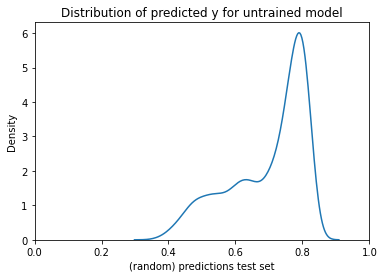

In [177]:
y_pred = model.predict(X_test)
sns.kdeplot(y_pred.squeeze())
plt.xlabel('(random) predictions test set')
plt.title('Distribution of predicted y for untrained model')
plt.xlim((0, 1));

In [178]:
num_epochs = 20
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=1500, validation_data=(X_dev, y_dev), verbose=1, callbacks=[early_stopping])

Epoch 1/20
34/34 [==============================] - 2s 29ms/step - loss: 0.5116 - accuracy: 0.7687 - val_loss: 0.3823 - val_accuracy: 0.8287
Epoch 2/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3785 - accuracy: 0.8323 - val_loss: 0.3584 - val_accuracy: 0.8369
Epoch 3/20
34/34 [==============================] - 1s 23ms/step - loss: 0.3624 - accuracy: 0.8426 - val_loss: 0.3620 - val_accuracy: 0.8336
Epoch 4/20
34/34 [==============================] - 1s 23ms/step - loss: 0.3505 - accuracy: 0.8466 - val_loss: 0.3541 - val_accuracy: 0.8403
Epoch 5/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3447 - accuracy: 0.8499 - val_loss: 0.3495 - val_accuracy: 0.8459
Epoch 6/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3413 - accuracy: 0.8536 - val_loss: 0.3471 - val_accuracy: 0.8474
Epoch 7/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3429 - accuracy: 0.8512 - val_loss: 0.3461 - val_accuracy: 0.8481
Epoch 8/20
34

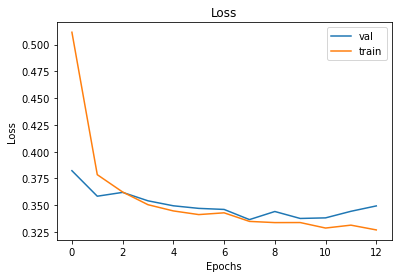

In [179]:
plt.plot(history.history['val_loss'],  label='val')
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

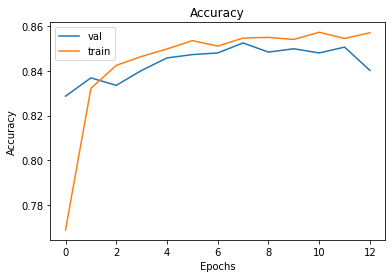

In [180]:
plt.plot(history.history['val_accuracy'],  label='val')
plt.plot(history.history['accuracy'], label='train')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [181]:
y_pred = model.predict(X_test) 
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [182]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8574973413683091
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2191
         1.0       0.72      0.60      0.65       630

    accuracy                           0.86      2821
   macro avg       0.80      0.77      0.78      2821
weighted avg       0.85      0.86      0.85      2821



Text(0.5, 33.0, 'Predicted Class')

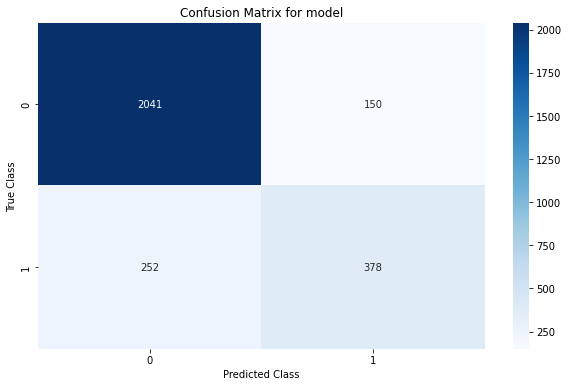

In [183]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize= (10,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for model")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

## Binary Classification

In [209]:
## Binary Classification

# Build model
model = Sequential()
model.add(Dense(1000, input_dim=20, activation='relu'))
model.add(Dense(700, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

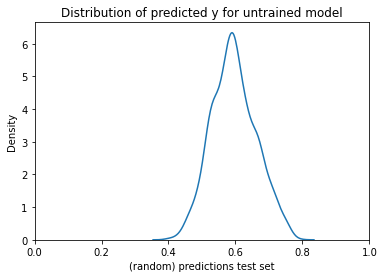

In [210]:
y_pred = model.predict(X_test)
sns.kdeplot(y_pred.squeeze())
plt.xlabel('(random) predictions test set')
plt.title('Distribution of predicted y for untrained model')
plt.xlim((0, 1));

In [211]:
num_epochs = 15
early_stopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights =True )
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(X_dev, y_dev), verbose=1, callbacks=[early_stopping])

Epoch 1/15
102/102 [==============================] - 1s 5ms/step - loss: 0.4167 - accuracy: 0.8221 - val_loss: 0.3490 - val_accuracy: 0.8444
Epoch 2/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3349 - accuracy: 0.8516 - val_loss: 0.3460 - val_accuracy: 0.8422
Epoch 3/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3244 - accuracy: 0.8571 - val_loss: 0.3378 - val_accuracy: 0.8478
Epoch 4/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3198 - accuracy: 0.8599 - val_loss: 0.3360 - val_accuracy: 0.8507
Epoch 5/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3181 - accuracy: 0.8590 - val_loss: 0.3344 - val_accuracy: 0.8545
Epoch 6/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3150 - accuracy: 0.8611 - val_loss: 0.3367 - val_accuracy: 0.8537
Epoch 7/15
102/102 [==============================] - 0s 4ms/step - loss: 0.3130 - accuracy: 0.8619 - val_loss: 0.3323 - val_accuracy: 0.8526
Epoch 

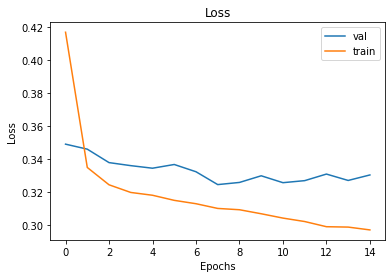

In [212]:
plt.plot(history.history['val_loss'],  label='val')
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

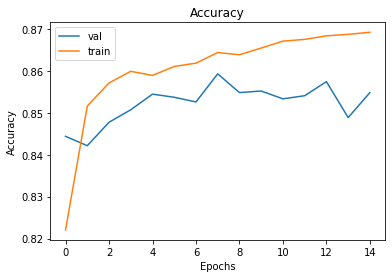

In [213]:
plt.plot(history.history['val_accuracy'],  label='val')
plt.plot(history.history['accuracy'], label='train')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [214]:
y_pred = model.predict(X_test) 
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [215]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8574973413683091
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      2191
         1.0       0.70      0.64      0.67       630

    accuracy                           0.86      2821
   macro avg       0.80      0.78      0.79      2821
weighted avg       0.85      0.86      0.86      2821



Text(0.5, 33.0, 'Predicted Class')

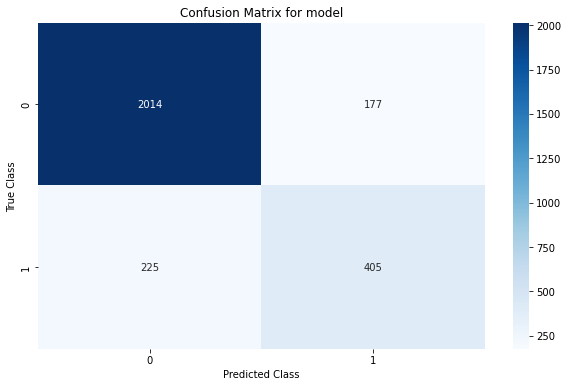

In [216]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize= (10,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for model")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')